# <center> GRANITES CLASSIFICATION

In [1]:
#utilitários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Pré processamento
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict


#Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb


#SMOTE
from imblearn.over_sampling import SMOTE

#Bayesian Optimization
from bayes_opt import BayesianOptimization

#Avaliadores
from sklearn.metrics import f1_score, precision_score, recall_score, \
    classification_report, accuracy_score, confusion_matrix, \
        ConfusionMatrixDisplay

from sklearn.utils import compute_sample_weight
from sklearn.model_selection import cross_val_score
import shap

#salvar e carregar modelos treinados
import joblib

#filtrando alertas
import warnings
warnings.filterwarnings("ignore")
xgb.set_config(verbosity=0)

#parâmetros para o matplotlib
plt.rcParams.update({'font.size': 14})

In [2]:
###################################################################################################
#funções usadas no notebook
###################################################################################################

def treino_de_classificadores(classificadores, X_treino, y_treino, pesos=None):
    '''Função de treino de classificadores e métricas'''
    for classificador in classificadores:
        classificador.fit(X_treino, np.ravel(y_treino), sample_weight=pesos)
        y_previsao = cross_val_predict(classificador, X_treino, y_treino, cv=10)
        precisao = precision_score(y_treino, y_previsao, average = 'weighted')
        revocacao = recall_score(y_treino, y_previsao, average = 'weighted')
        pontuacao_f1 = f1_score(y_treino, y_previsao, average = 'weighted')
        print(classificador.__class__.__name__)
        print(f'precisão:{precisao}, revocação:{revocacao}, F1 score: {pontuacao_f1}')
        
def teste_de_modelos(modelos, X_teste, y_teste):
    for modelo in modelos:
        previsoes_teste = modelo.predict(X_teste)
        print(modelo.__class__.__name__)
        print(classification_report(y_teste, previsoes_teste))
        print('_________________________________________________________________________________________________________')
        
def metricas_score(modelos, X_teste, y_teste, imb_treatment='No_treatment'): #imb_treatment
    '''Avialia modelos treinados com base em diferentes métricas'''
    metricas_modelo = {}
    for indice, modelo in enumerate(modelos):
        nome = modelo.__class__.__name__
        previsao = modelo.predict(X_teste)
        f1 = f1_score(y_teste, previsao, average='weighted')
        precisao = precision_score(y_teste, previsao, average='weighted')
        acuracia = accuracy_score(y_teste, previsao)
        imb_treatment = imb_treatment

        metricas_modelo[indice] = nome, f1, acuracia, precisao, imb_treatment
        
        
    return pd.DataFrame.from_dict(metricas_modelo, orient='index', columns=['Modelo', 'F1', 'Acurácia', 'Precisão', 'imb_treatment'])

## <center> LOADING AND PREPARING DATA

In [3]:
#Carregando o database tratado
database = pd.read_csv('dataset/GDB_Bonin(2020)_update.csv')

In [4]:
#Separando variáveis preditoras e variável alvo

database_preditores = database[['SiO2', 'TiO2', 'Al2O3','FeOt', 'MnO', 'MgO', 'CaO', 
                                'K2O', 'Na2O']]

database_alvo = database[['Group']]

## <center> EXPLORATORY DATA ANALYSIS

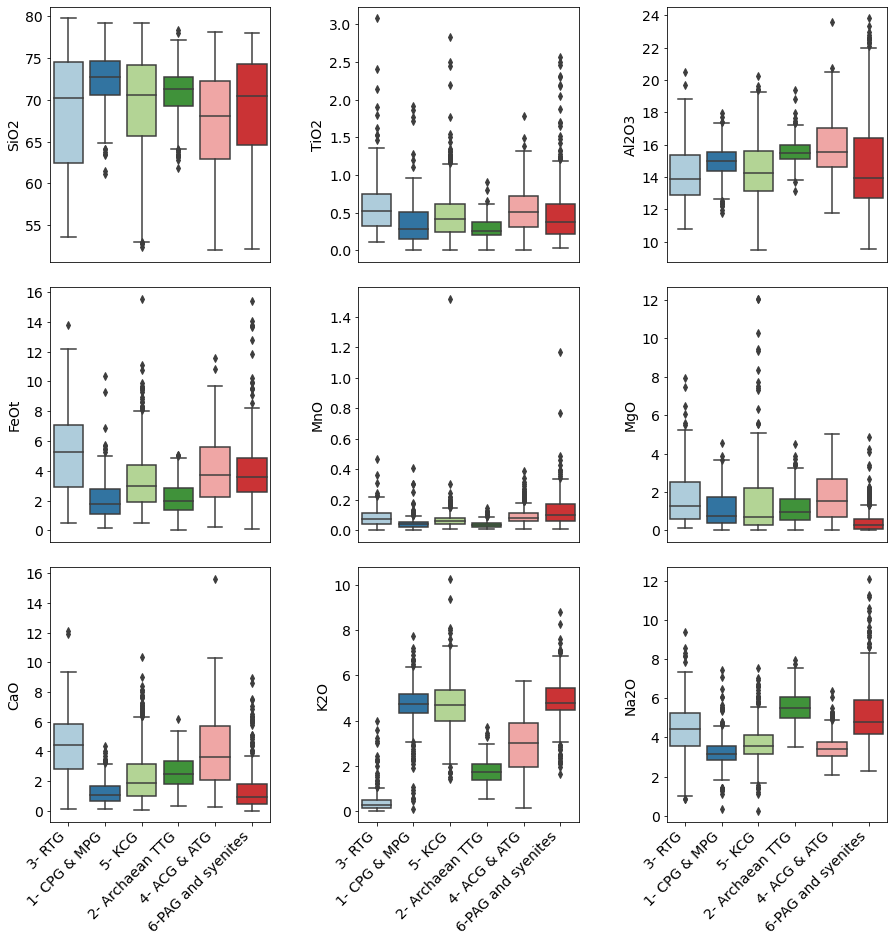

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))
plt.subplots_adjust(wspace=0.40, hspace=0.1)

contagem = 0
for i in range(0,2):
    for j in range(0,3):
        sns.boxplot(ax=axes[i, j], data=database_preditores, x=database_alvo['Group'], y=database_preditores.columns[contagem], palette="Paired")
        contagem += 1
plt.setp(axes, xticks=[], xlabel=None);

for i in range(2,3):
    for j in range(0,3):
        sns.boxplot(ax=axes[i, j], data=database_preditores, x=database_alvo['Group'], y=database_preditores.columns[contagem], palette="Paired")
        contagem += 1
        
for i in range(0,3):
    axes[2,i].set_xticklabels(axes[2,i].get_xticklabels(), rotation=45, ha='right')

plt.setp(axes, xlabel=None);
plt.savefig('boxplot.jpeg')

# <center> PRE PROCESSING DATA

In [6]:
#Realizando um amostragem estratificada
X_train, X_test, y_train, y_test = train_test_split(database_preditores, database_alvo, test_size=0.30, stratify=database_alvo, random_state=42)

scaler = StandardScaler()
encoder = LabelEncoder()
X_train_scaled = scaler.fit_transform(X_train)
y_train_encoded = encoder.fit_transform(y_train)

# <center> TRAINING BASE MODELS

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_clf = LinearDiscriminantAnalysis(n_components=3)
lda_model = lda_clf.fit(X_train_scaled, y_train_encoded).transform(X_train_scaled)

models_base = [lda_clf]
X_test_scaled = scaler.transform(X_test)
y_test_encoded = encoder.transform(y_test)


metricas_modelos = metricas_score(models_base, X_test_scaled, y_test_encoded, 'lda')
metricas_modelos

,Modelo,F1,Acurácia,Precisão,imb_treatment
0,LinearDiscriminantAnalysis,0.773976,0.774262,0.779591,lda


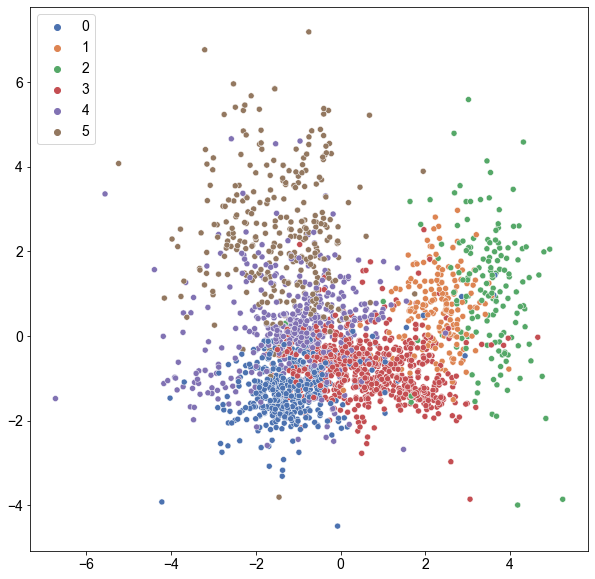

In [9]:
plt.subplots(figsize=(10,10))
sns.scatterplot(x=lda_model[:,0], y=lda_model[:,1], hue=y_train_encoded, palette="deep")
plt.legend(loc='upper left')
sns.set_style("whitegrid");


# <center> TRAINING AND TESTING THE BEST MODELS

In [70]:
# Base Models
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

modelos_base = [rf, xgb, lgbm]
treino_de_classificadores(modelos_base, X_train_scaled, y_train_encoded);

RandomForestClassifier
precisão:0.8633630360020598, revocação:0.86289592760181, F1 score: 0.8625586654228495
XGBClassifier
precisão:0.8618138914514063, revocação:0.8619909502262444, F1 score: 0.861745196286551
LGBMClassifier
precisão:0.8616031597015702, revocação:0.8610859728506788, F1 score: 0.8611655559861999


In [37]:
#Best Models

best_rf = RandomForestClassifier(bootstrap=False, max_features=3, criterion='entropy', n_estimators=100)
best_xgb = XGBClassifier(base_score=None, booster=None,
              colsample_bylevel=0.9322218967416926,
              colsample_bynode=0.7999563908598613,
              colsample_bytree=0.8533282163202267, enable_categorical=False,
              gamma=None, gpu_id=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11850546037192641,
              max_delta_step=None, max_depth=9, min_child_weight=None,
              monotone_constraints=None, n_estimators=183,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.6059572162284598,
              tree_method=None, validate_parameters=None, verbosity=None)

best_lgbm = lgb.LGBMClassifier()

modelos_best = [best_rf, best_xgb, best_lgbm]
#pesos = compute_sample_weight("balanced", y_train_encoded)
treino_de_classificadores(modelos, X_train_scaled, y_train_encoded);

In [41]:
# Best models + SMOTE
smote = SMOTE()
scaler_smt = StandardScaler()
encoder_smt = LabelEncoder()

X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)
X_train_smt_scaled = scaler_smt.fit_transform(X_train_smt)
y_train_smt_encoded = encoder_smt.fit_transform(y_train_smt)

modelos_smote = modelos_best
treino_de_classificadores(modelos_smote, X_train_smt_scaled, y_train_smt_encoded)

# Saving models
joblib.dump(rf,'models/RF_base.joblib')
joblib.dump(xgb,'models/XGB_base.joblib')
joblib.dump(lgbm ,'models/LGBM_base.joblib')

# Saving SMOTE models
joblib.dump(best_rf,'models/RF_smote.joblib')
joblib.dump(best_xgb,'models/XGB_smote.joblib')
joblib.dump(best_lgbm ,'models/LGBM_smote.joblib')

# <center> TRAINING AND TESTING THE BEST MODELS (SMOTE)

# <center> MODEL EVALUATION

In [47]:
#scaling test variables
X_test_scaled = scaler.transform(X_test)
y_test_encoded = encoder.transform(y_test)

#testing models
test_base = metricas_score(modelos_base, X_test_scaled, y_test_encoded, 'Base')
test_best = metricas_score(modelos_best, X_test_scaled, y_test_encoded, 'Best')
test_smote = metricas_score(modelos, X_test_scaled, y_test_encoded, 'SMOTE')

,Modelo,F1,Acurácia,Precisão,imb_treatment
0,RandomForestClassifier,0.857580,0.857595,0.857953,Base
1,XGBClassifier,0.863782,0.863924,0.864017,Base
2,LGBMClassifier,0.861933,0.861814,0.862919,Base


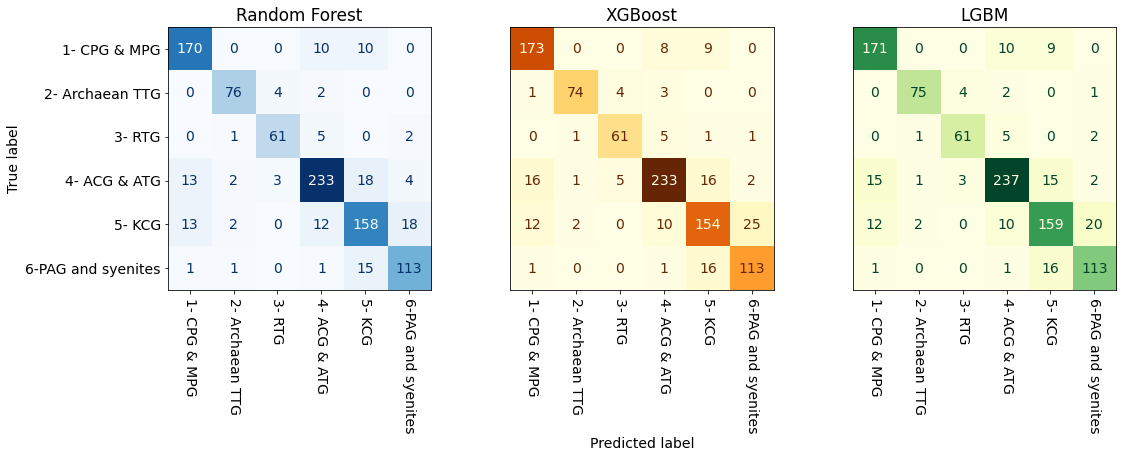

In [35]:
#predictions for test
random_forest_predictions = grid_rf.predict(X_test_scaled)
XGBboost_predictions = bo_xgb.predict(X_test_scaled)
LGBM_predictions = lgbm.predict(X_test_scaled)

#confusion matrix
conf_matrix1 = confusion_matrix(y_test_encoded, random_forest_predictions)
conf_matrix2 = confusion_matrix(y_test_encoded, XGBboost_predictions)
conf_matrix3 = confusion_matrix(y_test_encoded, LGBM_predictions)

#Displaying confusion matrix for random forest test
fig, ax = plt.subplots(1,3,figsize=(17, 15))
ax[0].set_title("Random Forest")
ax[1].set_title("XGBoost")
ax[2].set_title("LGBM")

cm = ConfusionMatrixDisplay(conf_matrix1,display_labels=encoder.classes_)
cm.plot(ax=ax[0], xticks_rotation=270,cmap='Blues', colorbar=False)
plt.setp(ax[0],xlabel=None)

# Displaying confusion matrix for XGBoost test
cm = ConfusionMatrixDisplay(conf_matrix2,display_labels=encoder.classes_)
cm.plot(ax=ax[1], xticks_rotation=270,cmap='YlOrBr', colorbar=False)
plt.setp(ax[1], yticks=[], ylabel=None)

# Displaying confusion matrix for ADABoost test
cm = ConfusionMatrixDisplay(conf_matrix3,display_labels=encoder.classes_)
cm.plot(ax=ax[2], xticks_rotation=270,cmap='YlGn', colorbar=False)
plt.setp(ax[2], yticks=[], ylabel=None ,xlabel=None)

plt.subplots_adjust(wspace=0.30, hspace=0.1)
plt.show()

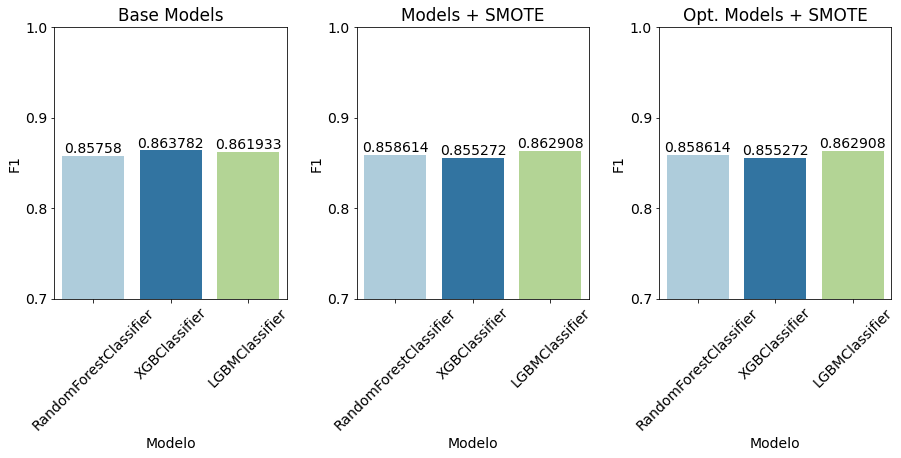

In [61]:
fig, ax = plt.subplots(1,3,figsize=(15, 5))

ax[0] = sns.barplot(ax=ax[0], x=models_base['Modelo'], y=models_base['F1'], data=models_base, palette="Paired")
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].set_yticks([0.6,0.7,0.8,0.9,1])
ax[0].tick_params(axis='y', colors='black');
ax[0].set_ylim(0.7,1)

ax[1] = sns.barplot(ax=ax[1], x=models_smote['Modelo'], y=models_smote['F1'], data=models_smote, palette="Paired")
for container in ax[1].containers:
    ax[1].bar_label(container)
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_yticks([0.7,0.8,0.9,1])
ax[1].tick_params(axis='y', colors='black');
ax[1].set_ylim(0.7, 1)

ax[2] = sns.barplot(ax=ax[2], x=models_smote['Modelo'], y=models_smote['F1'], data=models_smote, palette="Paired")
for container in ax[2].containers:
    ax[2].bar_label(container)
ax[2].tick_params(axis='x', labelrotation=45)
ax[2].set_yticks([0.7,0.8,0.9,1])
ax[2].tick_params(axis='y', colors='black');
ax[2].set_ylim(0.7, 1)

ax[0].set_title("Base Models")
ax[1].set_title("Models + SMOTE")
ax[2].set_title("Opt. Models + SMOTE")
plt.subplots_adjust(wspace=0.30, hspace=0.1)

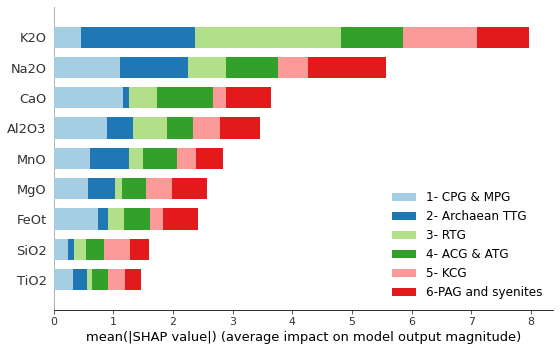

In [58]:
explainer_xgb = shap.TreeExplainer(bo_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_train_scaled)

shap.summary_plot(shap_values_xgb, X_train_scaled, feature_names=X_train.columns,
                  class_names=encoder.classes_,class_inds='original',
                  color=plt.get_cmap("Paired"))

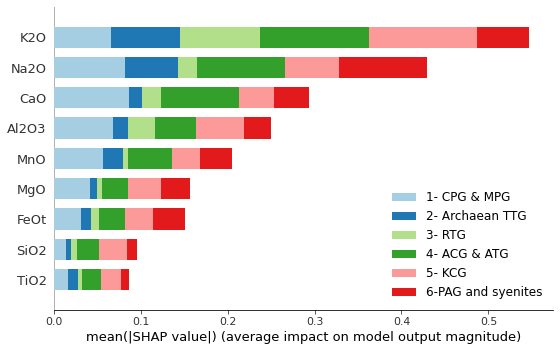

In [59]:
explainer_rf = shap.TreeExplainer(grid_rf)
shap_values_rf = explainer_rf.shap_values(X_train_scaled)

shap.summary_plot(shap_values_rf, X_train_scaled, feature_names=X_train.columns,
                  class_names=encoder.classes_,class_inds='original',
                  color=plt.get_cmap("Paired"))

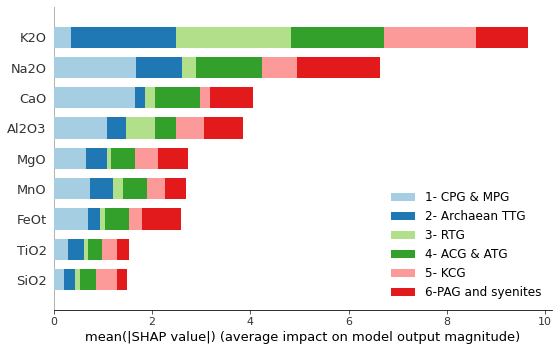

In [60]:
explainer_lgbm = shap.TreeExplainer(lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(X_train_scaled)

shap.summary_plot(shap_values_lgbm, X_train_scaled, feature_names=X_train.columns,
                  class_names=encoder.classes_,class_inds='original',
                  color=plt.get_cmap("Paired"))